In [1]:
%load_ext autoreload
%autoreload 2

from propose.datasets.human36m.Human36mDataset import NewestHumanDatasetNoRoot, Human36mDataset
from propose.poses.human36m import Human36mPose

from torch_geometric.loader import DataLoader

import propose.datasets.rat7m.transforms as tr
import propose.datasets.graph_transforms as trg

from propose.models.flows.CondGraphFlow import CondGraphFlow
from propose.training import prior_trainer, supervised_trainer
from propose.models.nn.embedding import SageEmbedding, FlatMLPEmbedding

import torch

import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns

from tqdm import tqdm
from matplotlib.lines import Line2D

In [2]:
embedding_net = SageEmbedding(2, 128, 10)  # FlatMLPEmbedding(15 * 2, 128, 16 * 10)
flow = CondGraphFlow(num_layers=10, context_features=10, hidden_features=100, embedding_net=embedding_net,
                     use_attention=False)
flow.load_state_dict(
    torch.load(f"../../data/models/53c1b15122a1392b523dcbec3f6954da", map_location=torch.device('cpu')), strict=False)

flow.eval();

In [3]:
test_dataset = Human36mDataset(
    dirname='../../data/human36m/processed/test',
    occlusion_fractions=[],
    mpii=True,
    test=True,
)

Preparing test dataset: 100%|██████████| 8486/8486 [00:02<00:00, 3279.68it/s]


In [4]:
from tqdm import tqdm
from matplotlib.lines import Line2D

sns.set_context('talk')

torch.manual_seed(1)

n_poses = 3
viz_dataloader = DataLoader(test_dataset, batch_size=n_poses, shuffle=True, pin_memory=False, num_workers=0)
batch, _, config = next(iter(viz_dataloader))

original = batch['x'].x.numpy().reshape(-1, 16, 3)
original_2d = batch['c'].x.numpy()

original = np.insert(original, 0, 0, axis=1)
original_2d = np.insert(original_2d, 0, 0, axis=0)

og_pose = Human36mPose(original)
og_pose_2d = Human36mPose(original_2d)

print('Sampling Poses')
n_samples = 200
samples = flow.sample(n_samples, batch)
print(f'Sampled {n_poses*n_samples:,} poses')

sample_poses = samples['x'].x.detach().cpu().numpy().reshape(-1, 16, n_samples, 3)
sample_poses = np.insert(sample_poses, 0, 0, axis=1)
sample_poses = sample_poses.swapaxes(1, 2)

poses = Human36mPose(sample_poses)

Sampling Poses
Sampled 600 poses


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.proj3d import proj_transform
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib.patches import FancyArrowPatch, ArrowStyle
class Arrow3D(FancyArrowPatch):

    def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._xyz = (x, y, z)
        self._dxdydz = (dx, dy, dz)

    def draw(self, renderer):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        super().draw(renderer)
        
    def do_3d_projection(self, renderer=None):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))

        return np.min(zs)

def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
    '''Add an 3d arrow to an `Axes3D` instance.'''

    arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
    ax.add_artist(arrow)


setattr(Axes3D, 'arrow3D', _arrow3D)

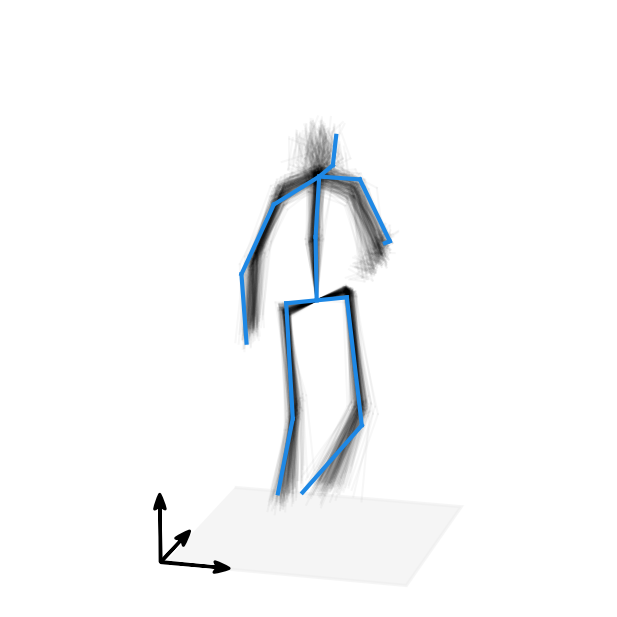

In [6]:
fig = plt.figure(figsize=(4, 5), dpi=150, constrained_layout=True)
ax = plt.subplot(1, 1, 1, projection='3d')
ax.view_init(15, 15-90)
og_pose[0].plot(ax, plot_type='None', c='#1E88E5', lw=2)
poses[0].plot(ax, plot_type='None', c='k', alpha=.03, lw=1, zorder=1)

points = poses[1].pose_matrix[:, 16].T

arrowstyle = ArrowStyle.Fancy(head_width=5, head_length=7)
ax.arrow3D(1.5-3.15, 1.5-3.1, -3.1,
           1, 0, 0,
          arrowstyle=arrowstyle,
           mutation_scale=1,
          color='k')
ax.arrow3D(1.5-3.1, 1.5-3.15, -3.1,
           0, 1.4, 0,
          arrowstyle=arrowstyle,
          mutation_scale=1,
          color='k')
ax.arrow3D(1.5-3.1, 1.5-3.1, -3.15,
           0, 0, 1,
          arrowstyle=arrowstyle,
          mutation_scale=1,
          color='k')

ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_zlim(-3, 3)

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))        
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

legend_elements = [Line2D([0], [0], color='#1E88E5', label='Ground Truth'),
                           Line2D([0], [0], color='k', alpha=1, label='Samples'),
                   plt.scatter([-100], [-100], color='#EDAC32', label='Occluded Samples', s=50)
                          ]

# ax.legend(handles=legend_elements, frameon=False)
plt.gca().set_box_aspect(aspect=(0.5, 0.5, 1))

plt.gca().set_rasterization_zorder(2)

plt.savefig('./pose_projected_1.pdf', dpi=150, bbox_inches='tight')

plt.show()

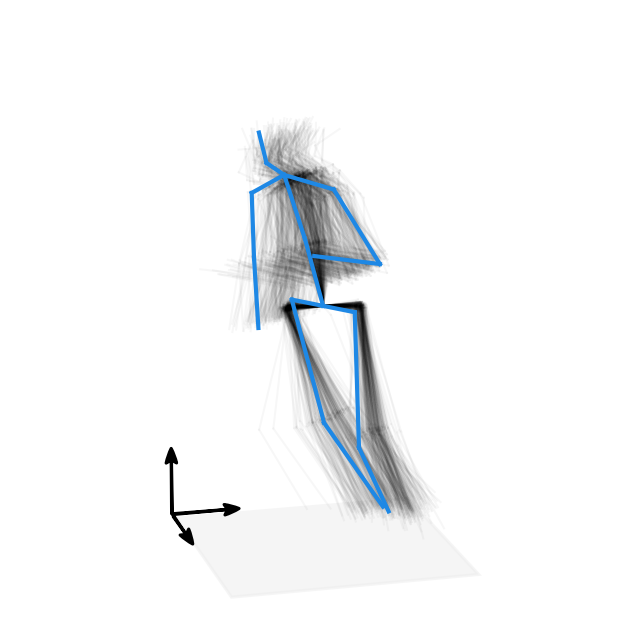

In [7]:

fig = plt.figure(figsize=(4, 5), dpi=150)
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
ax = plt.subplot(1, 1, 1, projection='3d')
ax.view_init(15, 15-90+60)
poses[0].plot(ax, plot_type='None', c='k', alpha=.03, lw=1, rasterized=True)
og_pose[0].plot(ax, plot_type='None', c='#1E88E5', lw=2)

points = poses[1].pose_matrix[:, 16].T
# ax.scatter(*points, c='#EDAC32', zorder=-10, s=1, label='Occluded Hypotheses')

arrowstyle = ArrowStyle.Fancy(head_width=5, head_length=7)
ax.arrow3D(1.5-3.15, 1.5-3.1, -3.1,
           1.4, 0, 0,
          arrowstyle=arrowstyle,
           mutation_scale=1,
          color='k')
ax.arrow3D(1.5-3.1, 1.5-3.15, -3.1,
           0, 1, 0,
          arrowstyle=arrowstyle,
          mutation_scale=1,
          color='k')
ax.arrow3D(1.5-3.1, 1.5-3.1, -3.15,
           0, 0, 1,
          arrowstyle=arrowstyle,
          mutation_scale=1,
          color='k')

ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_zlim(-3, 3)

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

legend_elements = [Line2D([0], [0], color='#1E88E5', label='Ground Truth'),
                           Line2D([0], [0], color='k', alpha=1, label='Samples'),
                   plt.scatter([-100], [-100], color='#EDAC32', label='Occluded Samples', s=50)
                          ]

plt.gca().set_box_aspect(aspect=(0.5, 0.5, 1))

plt.savefig('./pose_projected_1_rt.pdf', dpi=150, bbox_inches='tight')

plt.show()

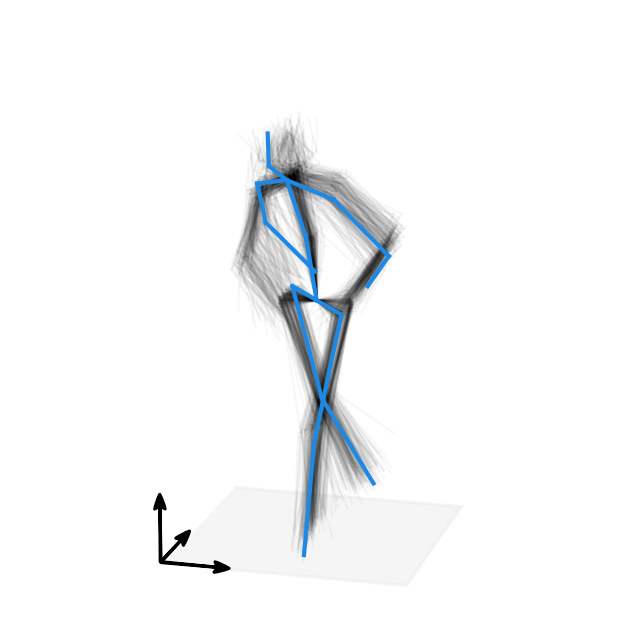

In [8]:
fig = plt.figure(figsize=(4, 5), dpi=150, constrained_layout=True)
ax = plt.subplot(1, 1, 1, projection='3d')
ax.view_init(15, 15-90)
og_pose[2].plot(ax, plot_type='None', c='#1E88E5', lw=2)
poses[2].plot(ax, plot_type='None', c='k', alpha=.03, lw=1, zorder=1)

arrowstyle = ArrowStyle.Fancy(head_width=5, head_length=7)
ax.arrow3D(1.5-3.15, 1.5-3.1, -3.1,
           1, 0, 0,
          arrowstyle=arrowstyle,
           mutation_scale=1,
          color='k')
ax.arrow3D(1.5-3.1, 1.5-3.15, -3.1,
           0, 1.4, 0,
          arrowstyle=arrowstyle,
          mutation_scale=1,
          color='k')
ax.arrow3D(1.5-3.1, 1.5-3.1, -3.15,
           0, 0, 1,
          arrowstyle=arrowstyle,
          mutation_scale=1,
          color='k')

ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_zlim(-3, 3)

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

legend_elements = [Line2D([0], [0], color='#1E88E5', label='Ground Truth'),
                           Line2D([0], [0], color='k', alpha=1, label='Samples'),
                   plt.scatter([-100], [-100], color='#EDAC32', label='Occluded Samples', s=50)
                          ]

# ax.legend(handles=legend_elements, frameon=False)
plt.gca().set_box_aspect(aspect=(0.5, 0.5, 1))

plt.gca().set_rasterization_zorder(2)

plt.savefig('./pose_projected_2.pdf', dpi=150, bbox_inches='tight')

plt.show()

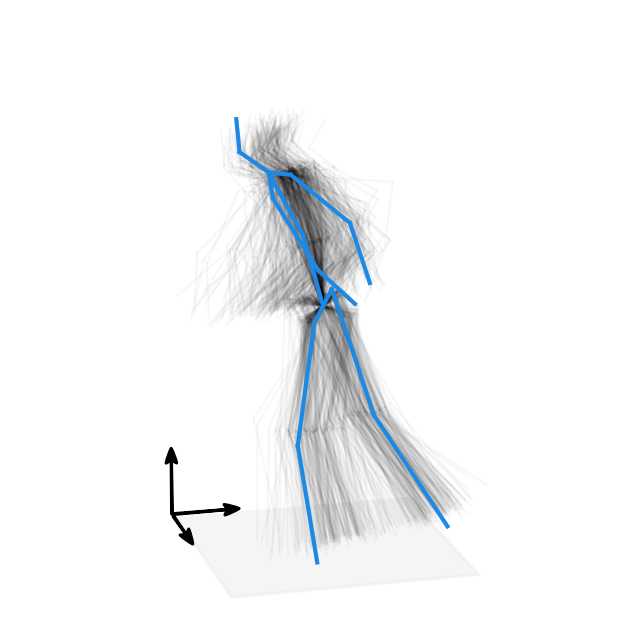

In [9]:
fig = plt.figure(figsize=(4, 5), dpi=150)
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
ax = plt.subplot(1, 1, 1, projection='3d')
ax.view_init(15, 15-90+60)
poses[2].plot(ax, plot_type='None', c='k', alpha=.03, lw=1, rasterized=True)
og_pose[2].plot(ax, plot_type='None', c='#1E88E5', lw=2)


arrowstyle = ArrowStyle.Fancy(head_width=5, head_length=7)
ax.arrow3D(1.5-3.15, 1.5-3.1, -3.1,
           1.4, 0, 0,
          arrowstyle=arrowstyle,
           mutation_scale=1,
          color='k')
ax.arrow3D(1.5-3.1, 1.5-3.15, -3.1,
           0, 1, 0,
          arrowstyle=arrowstyle,
          mutation_scale=1,
          color='k')
ax.arrow3D(1.5-3.1, 1.5-3.1, -3.15,
           0, 0, 1,
          arrowstyle=arrowstyle,
          mutation_scale=1,
          color='k')

ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_zlim(-3, 3)

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

legend_elements = [Line2D([0], [0], color='#1E88E5', label='Ground Truth'),
                           Line2D([0], [0], color='k', alpha=1, label='Samples'),
                   plt.scatter([-100], [-100], color='#EDAC32', label='Occluded Samples', s=50)
                          ]

plt.gca().set_box_aspect(aspect=(0.5, 0.5, 1))

plt.savefig('./pose_projected_2_rt.pdf', dpi=150, bbox_inches='tight')

plt.show()

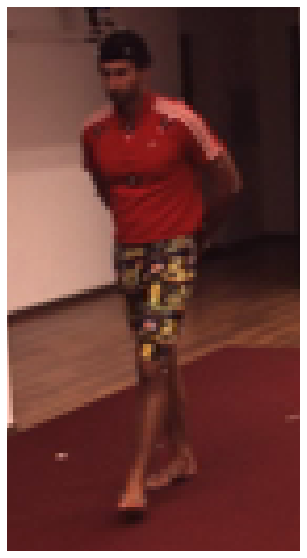

In [10]:
img = plt.imread('./Walking.58860488.764.png')

plt.figure(figsize=(10, 10))
plt.imshow(img)

center = config['center3d'][2].numpy()

pose_matrix = og_pose[2].pose_matrix.copy()
pose_matrix[:, 2] = -pose_matrix[:, 2]
pose_matrix[:, [1, 2]] = pose_matrix[:, [2, 1]]
pose = (pose_matrix / 0.0036 + center)

plt.xlim(100, 170)
plt.ylim(190, 60)
plt.axis('off')
plt.savefig('./pose_1_image.png', bbox_inches='tight')

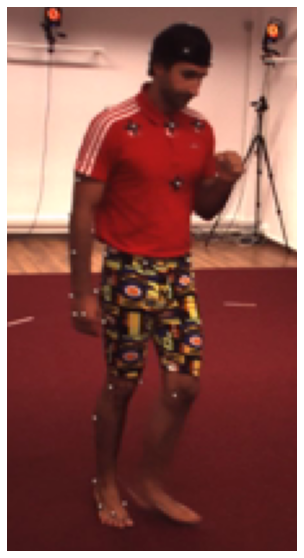

In [11]:
img = plt.imread('./Walking1.60457274.2032.png')

plt.figure(figsize=(10, 10))
plt.imshow(img)

plt.xlim(64, 176)
plt.ylim(240, 30)
plt.axis('off')
plt.savefig('./pose_2_image.png', bbox_inches='tight')
plt.show()

  0%|          | 0/6 [00:00<?, ?it/s]

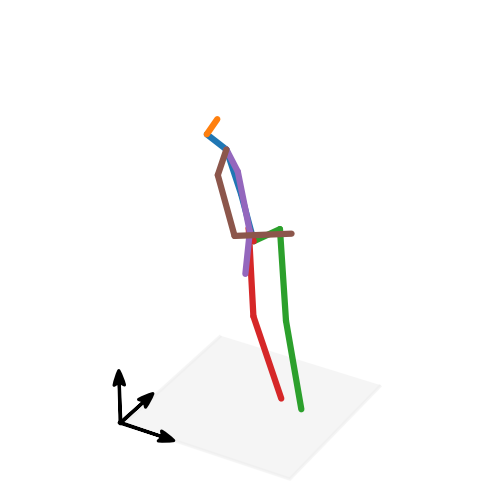

 17%|█▋        | 1/6 [00:00<00:01,  4.45it/s]

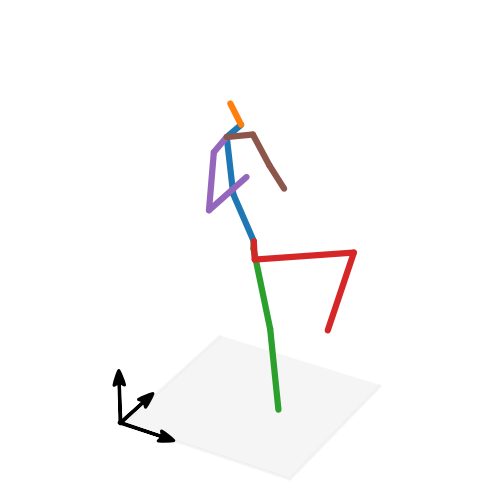

 33%|███▎      | 2/6 [00:00<00:00,  5.17it/s]

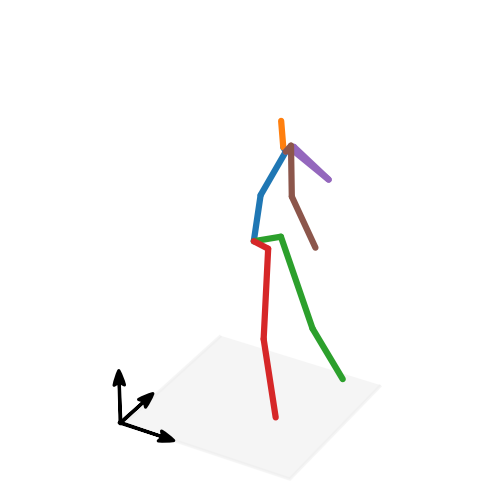

 50%|█████     | 3/6 [00:00<00:00,  5.57it/s]

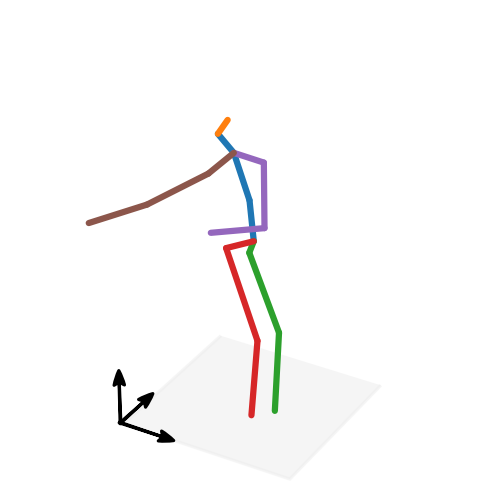

 67%|██████▋   | 4/6 [00:00<00:00,  5.76it/s]

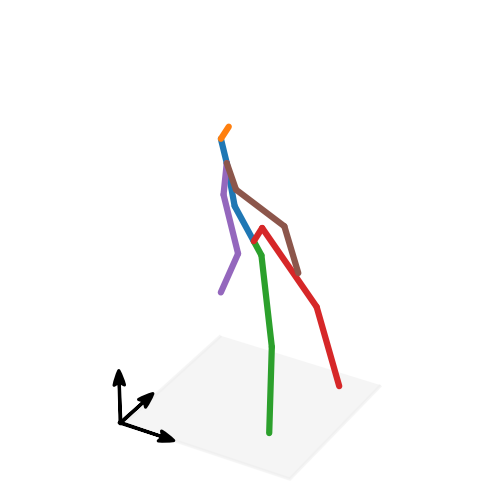

 83%|████████▎ | 5/6 [00:00<00:00,  5.93it/s]

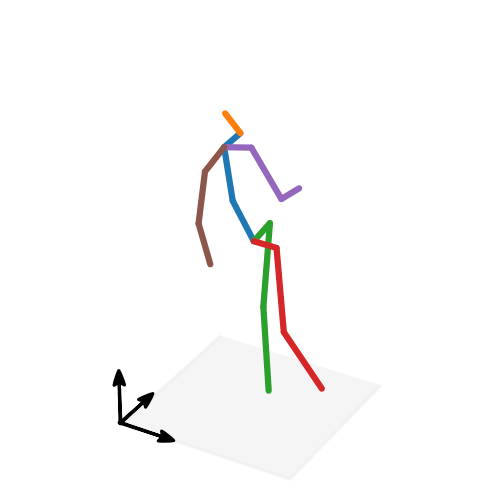

100%|██████████| 6/6 [00:01<00:00,  5.69it/s]


In [12]:
torch.manual_seed(2)

viz_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True, pin_memory=False, num_workers=0)
_, batch, config = next(iter(viz_dataloader))

original = batch['x'].x.numpy()

original = np.insert(original, 0, 0, 0)

samples = flow.sample(30, batch)

sample_poses = samples['x'].x.detach().cpu().numpy()
sample_poses = np.insert(sample_poses, 0, 0, 0)
sample_poses = sample_poses.swapaxes(0, 1)

poses = Human36mPose(sample_poses)

mode = flow.mode_sample(batch)['x']['x'].detach().cpu().numpy()
mode = np.insert(mode, 0, 0, 0)
mode = mode.swapaxes(0, 1)
mode = Human36mPose(mode)

with sns.axes_style('whitegrid'):
    for i in tqdm(range(6)):
        fig = plt.figure(figsize=(4, 5), dpi=150)
        fig.subplots_adjust(wspace=0, hspace=0)
        ax = plt.subplot(1, 1, 1, projection='3d')
        ax.view_init(30, 30)
        poses[i].plot(ax, lw=3)

        arrowstyle = ArrowStyle.Fancy(head_width=5, head_length=7)
        ax.arrow3D(3.2 - 1.5, 1.5-3.1, -3.1,
                   -1.2, 0, 0,
                  arrowstyle=arrowstyle,
                   mutation_scale=1,
                  color='k')
        ax.arrow3D(3.1- 1.5, 1.5-3.2, -3.1,
                   0, 1.2, 0,
                  arrowstyle=arrowstyle,
                  mutation_scale=1,
                  color='k')
        ax.arrow3D(3.1- 1.5, 1.5-3.1, -3.2,
                   0, 0, 1.2,
                  arrowstyle=arrowstyle,
                  mutation_scale=1,
                  color='k')

        ax.set_xlim(-1.5, 1.5)
        ax.set_ylim(-1.5, 1.5)
        ax.set_zlim(-3, 3)

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])

        ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
        ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))        
        ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
        
        ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

        legend_elements = [Line2D([0], [0], color='cyan', label='Ground Truth'),
                           Line2D([0], [0], color='k', alpha=1, label='Samples'),
                          ]

        plt.gca().set_box_aspect(aspect=(0.5, 0.5, 1))

        plt.savefig(f'./prior_poses_{i}.pdf', bbox_inches='tight', dpi=150)
        plt.show()

# Supplementary Figures

100%|██████████| 8/8 [00:00<00:00, 15.82it/s]


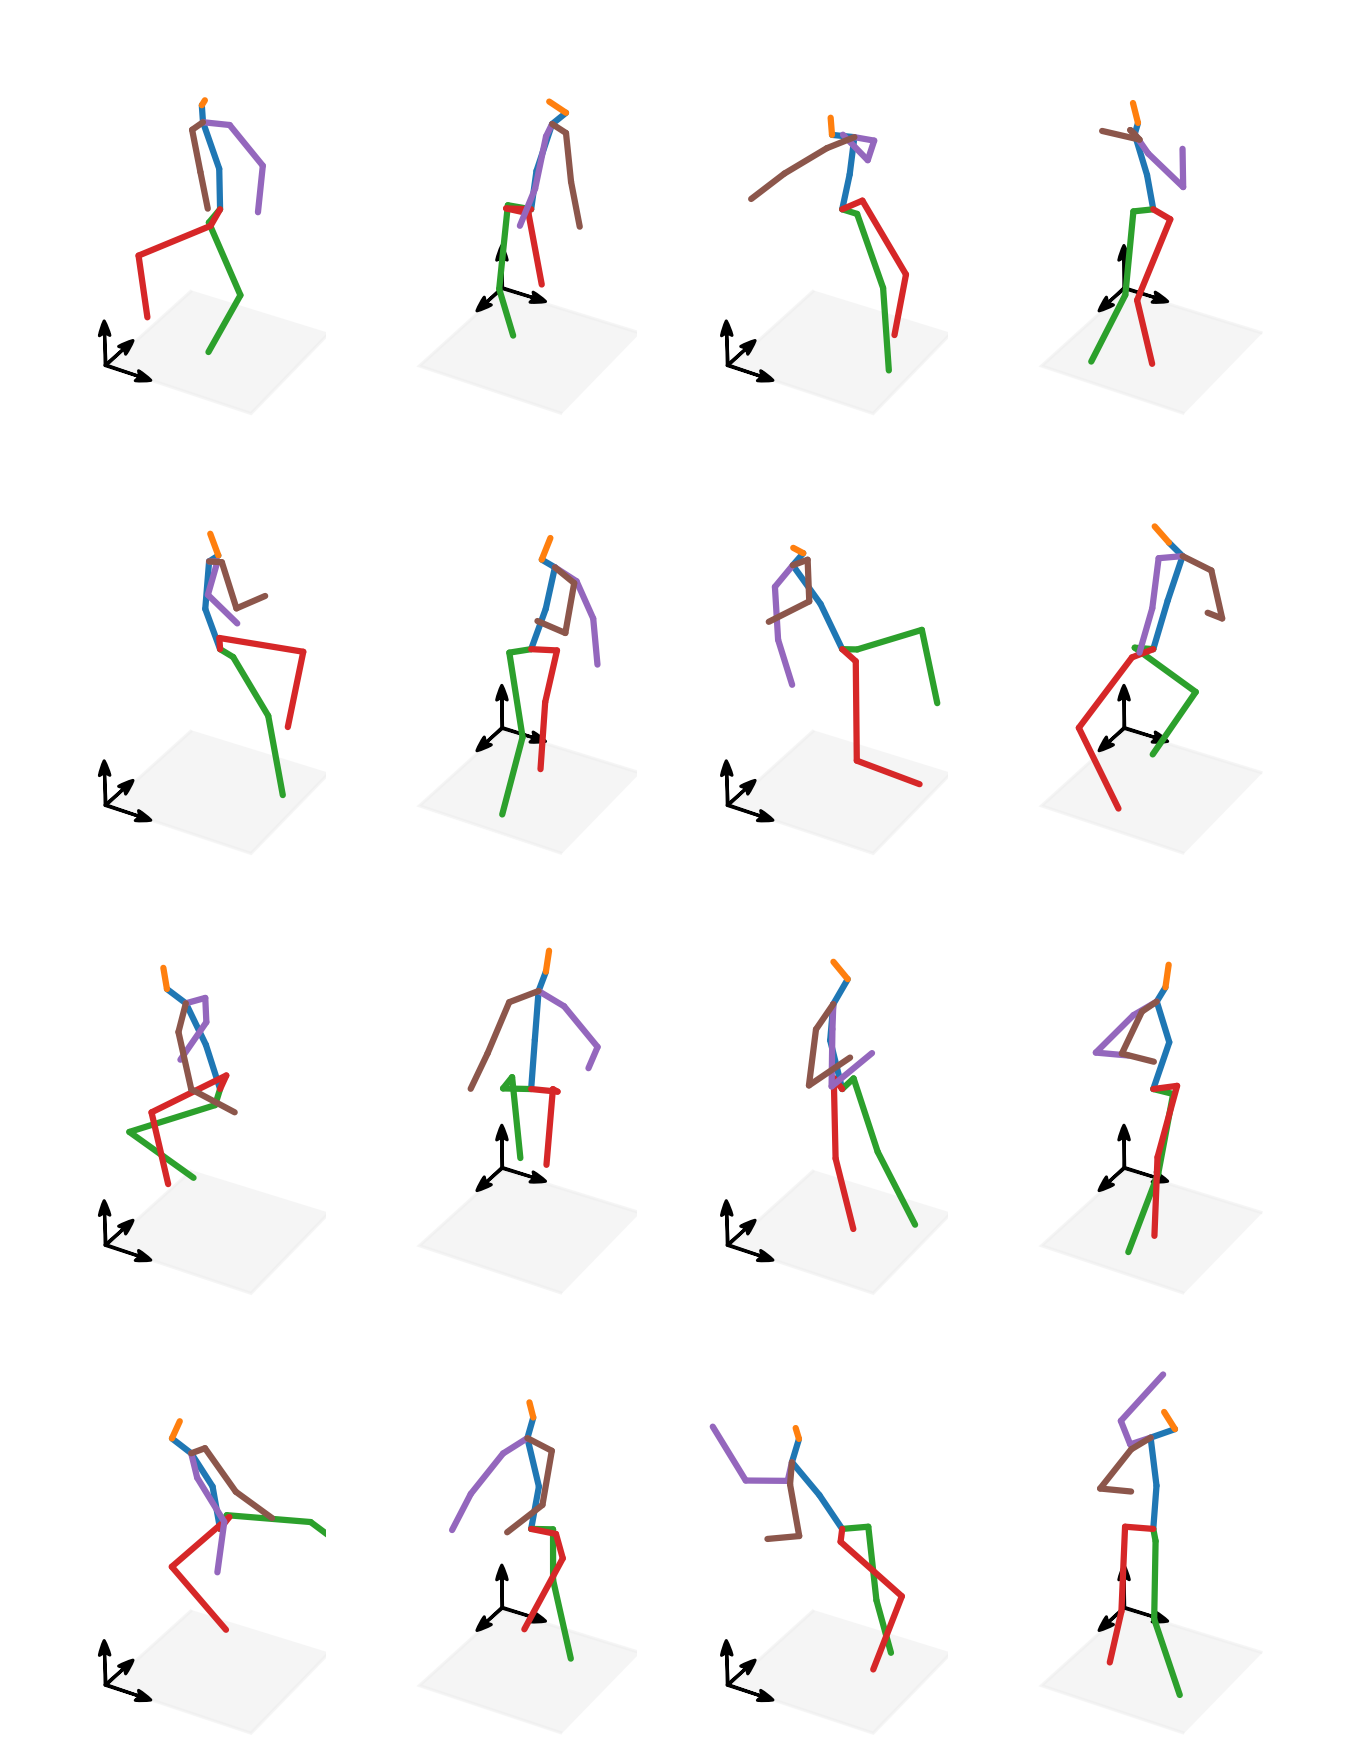

In [13]:
from tqdm import tqdm

torch.manual_seed(3)

viz_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True, pin_memory=False, num_workers=0)
_, batch, config = next(iter(viz_dataloader))

original = batch['x'].x.numpy()

original = np.insert(original, 0, 0, 0)

samples = flow.sample(30, batch)

sample_poses = samples['x'].x.detach().cpu().numpy()
sample_poses = np.insert(sample_poses, 0, 0, 0)
sample_poses = sample_poses.swapaxes(0, 1)

poses = Human36mPose(sample_poses)

mode = flow.mode_sample(batch)['x']['x'].detach().cpu().numpy()
mode = np.insert(mode, 0, 0, 0)
mode = mode.swapaxes(0, 1)
mode = Human36mPose(mode)

sns.set_context('talk')
with sns.axes_style('whitegrid'):
    fig = plt.figure(figsize=(12, 12), dpi=150)
    fig.subplots_adjust(wspace=0, hspace=0, left=-1)
    for i in tqdm(range(8)):
        for j in range(2):
            ax = plt.subplot(4, 4, i * 2 + j + 1, projection='3d')
            
            ax.dist = 1
            
            if not j:
                ax.view_init(30, 30)
            else:
                ax.view_init(30, 120)

            poses[i + 4].plot(ax, lw=3, zorder=10)

            arrowstyle = ArrowStyle.Fancy(head_width=5, head_length=7)
            ax.arrow3D(3.2 - 1.5, 1.5-3.1, -3.1,
                   -1.2, 0, 0,
                  arrowstyle=arrowstyle,
                   mutation_scale=1,
                  color='k', zorder=-1)
            ax.arrow3D(3.1- 1.5, 1.5-3.2, -3.1,
                       0, 1.2, 0,
                      arrowstyle=arrowstyle,
                      mutation_scale=1,
                      color='k', zorder=-1)
            ax.arrow3D(3.1- 1.5, 1.5-3.1, -3.2,
                       0, 0, 1.2,
                      arrowstyle=arrowstyle,
                      mutation_scale=1,
                      color='k', zorder=-1)

            ax.set_xlim(-1.5, 1.5)
            ax.set_ylim(-1.5, 1.5)
            ax.set_zlim(-3, 3)

            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_zticks([])

            ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
            ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))        
            ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

            ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
            ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

            ax.set_box_aspect(aspect=(0.5, 0.5, 1))

            legend_elements = [Line2D([0], [0], color='cyan', label='Ground Truth'),
                               Line2D([0], [0], color='k', alpha=1, label='Samples'),
                              ]
plt.tight_layout()
plt.savefig(f'./combined_prior.pdf', bbox_inches='tight', dpi=150)
plt.show()

Sampling Poses


100%|██████████| 4/4 [00:05<00:00,  1.41s/it]


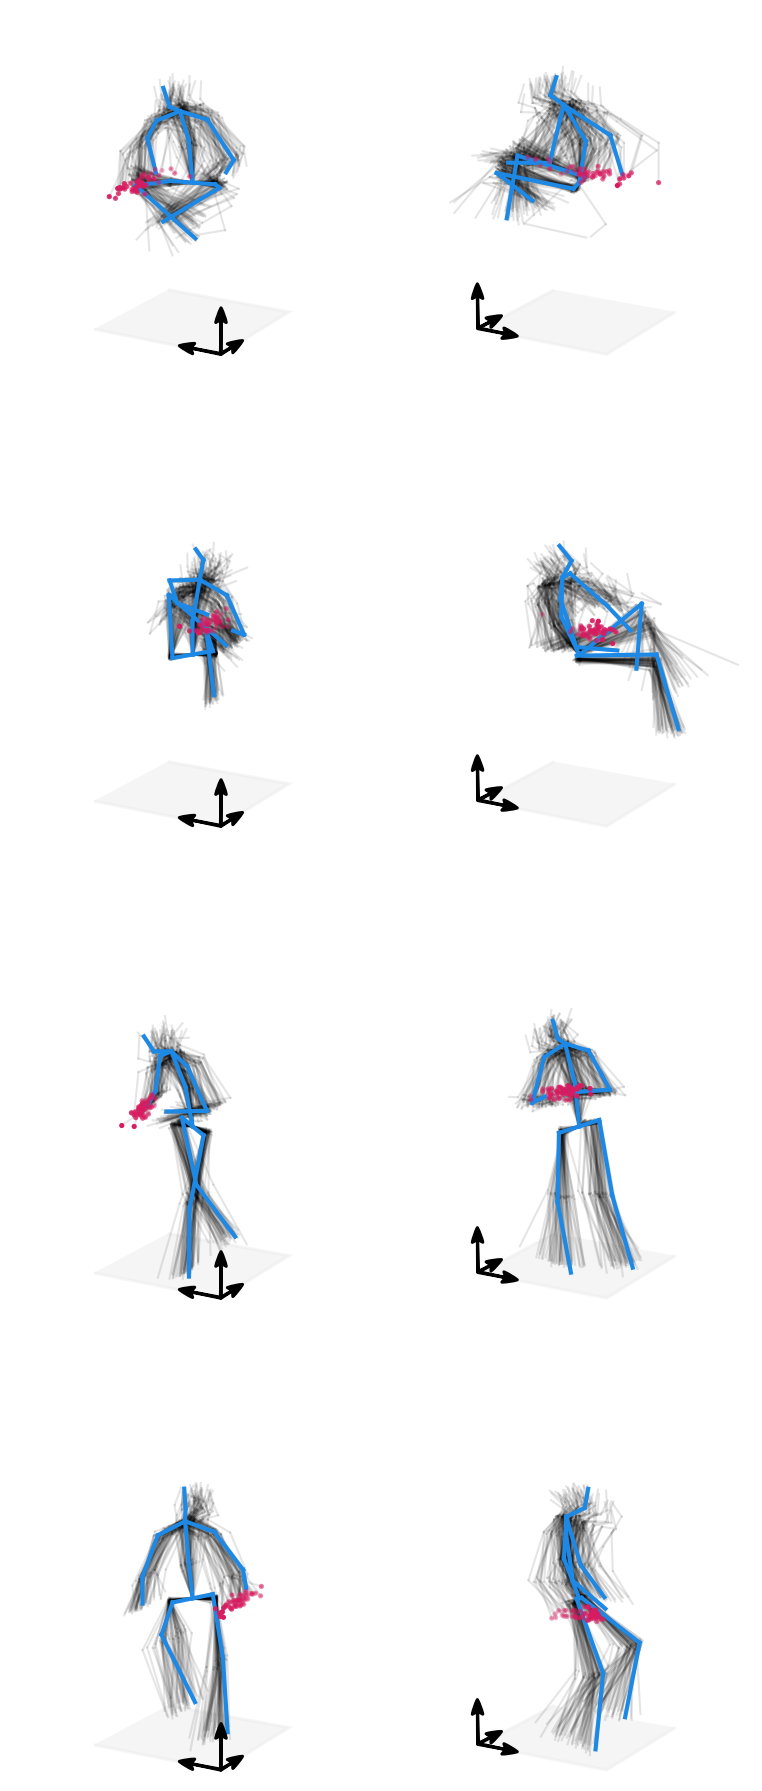

In [14]:
imgs = ['./human36m_images/Walking1.60457274.2032.png', './human36m_images/Directions1.58860488.812.png', './human36m_images/Walking.58860488.764.png', './human36m_images/SittingDown1.60457274.1272.png', './human36m_images/Smoking1.54138969.3540.png', './human36m_images/Phoning1.58860488.284.png']

torch.manual_seed(1)

n_poses = 7
viz_dataloader = DataLoader(test_dataset, batch_size=n_poses, shuffle=True, pin_memory=False, num_workers=0)
batch, _, config = next(iter(viz_dataloader))

original = batch['x'].x.numpy().reshape(-1, 16, 3)
original_2d = batch['c'].x.numpy()

original = np.insert(original, 0, 0, axis=1)
original_2d = np.insert(original_2d, 0, 0, axis=0)

og_pose = Human36mPose(original)
og_pose_2d = Human36mPose(original_2d)

print('Sampling Poses')
n_samples = 50
samples = flow.sample(n_samples, batch)

sample_poses = samples['x'].x.detach().cpu().numpy().reshape(-1, 16, n_samples, 3)
sample_poses = np.insert(sample_poses, 0, 0, axis=1)
sample_poses = sample_poses.swapaxes(1, 2)

poses = Human36mPose(sample_poses)

fig = plt.figure(figsize=(8, 4 * 4), dpi=150)
for i in tqdm(range(3, n_poses)):
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    
    ax = plt.subplot(5, 3, 1 + (i-2) * 3, projection='3d')
    
    ax.view_init(15, -60)
    poses[i].plot(ax, plot_type='None', c='k', alpha=.1, lw=1)
    og_pose[i].plot(ax, plot_type='None', c='#1E88E5', lw=2)

    points = poses[i].pose_matrix[:, 16].T
    ax.scatter(*points, c='#D81B60', zorder=-10, s=1, label='Occluded Hypotheses')

    arrowstyle = ArrowStyle.Fancy(head_width=5, head_length=7)
    ax.arrow3D(3.2 - 1.5, 1.5-3.1, -3.1,
           -1.2, 0, 0,
          arrowstyle=arrowstyle,
           mutation_scale=1,
          color='k', zorder=-1)
    ax.arrow3D(3.1- 1.5, 1.5-3.2, -3.1,
               0, 1.2, 0,
              arrowstyle=arrowstyle,
              mutation_scale=1,
              color='k', zorder=-1)
    ax.arrow3D(3.1- 1.5, 1.5-3.1, -3.2,
               0, 0, 1.2,
              arrowstyle=arrowstyle,
              mutation_scale=1,
              color='k', zorder=-1)

    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.set_zlim(-3, 3)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

    ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))        
    ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

    ax.set_box_aspect(aspect=(0.5, 0.5, 1))

    if not i:
        legend_elements = [Line2D([0], [0], color='cyan', label='Ground Truth'),
                                   Line2D([0], [0], color='k', alpha=1, label='Samples'),
                           plt.scatter([-100], [-100], color='#D81B60', label='Wrist Hypotheses', s=50)
                                  ]

        ax.legend(handles=legend_elements, frameon=False)
        
    ax = plt.subplot(5, 3, 2 + (i-2) * 3, projection='3d')
    
    ax.view_init(15, 30)
    poses[i].plot(ax, plot_type='None', c='k', alpha=.1, lw=1)
    og_pose[i].plot(ax, plot_type='None', c='#1E88E5', lw=2)

    points = poses[i].pose_matrix[:, 16].T
    ax.scatter(*points, c='#D81B60', zorder=-10, s=1, label='Occluded Hypotheses')

    arrowstyle = ArrowStyle.Fancy(head_width=5, head_length=7)
    ax.arrow3D(3.2 - 1.5, 1.5-3.1, -3.1,
           -1.2, 0, 0,
          arrowstyle=arrowstyle,
           mutation_scale=1,
          color='k', zorder=-1)
    ax.arrow3D(3.1- 1.5, 1.5-3.2, -3.1,
               0, 1.2, 0,
              arrowstyle=arrowstyle,
              mutation_scale=1,
              color='k', zorder=-1)
    ax.arrow3D(3.1- 1.5, 1.5-3.1, -3.2,
               0, 0, 1.2,
              arrowstyle=arrowstyle,
              mutation_scale=1,
              color='k', zorder=-1)

    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.set_zlim(-3, 3)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

    ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))        
    ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

    ax.set_box_aspect(aspect=(0.5, 0.5, 1))

plt.tight_layout()
plt.savefig('./supplementary_pose.png', dpi=150, bbox_inches='tight')